# Amazon Reviews Single Category Analysis

## Import Data

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from textblob import TextBlob

# Load data
df = pd.read_csv(<"input the tsv file">, sep='\t', on_bad_lines='skip', low_memory=False)

# Drop missing values in essential fields
df = df.dropna(subset=["review_headline", "review_body", "review_date"])

# Sample a fraction of the data
sample_fraction = 0.2
df = df.sample(frac=sample_fraction, random_state=42).reset_index(drop=True)

# Convert review_date to datetime
df['review_date'] = pd.to_datetime(df['review_date'], errors='coerce')
df = df.dropna(subset=["review_date"])

# Remove duplicates
df = df.drop_duplicates(subset="review_id")


## Exploratory Data Analysis

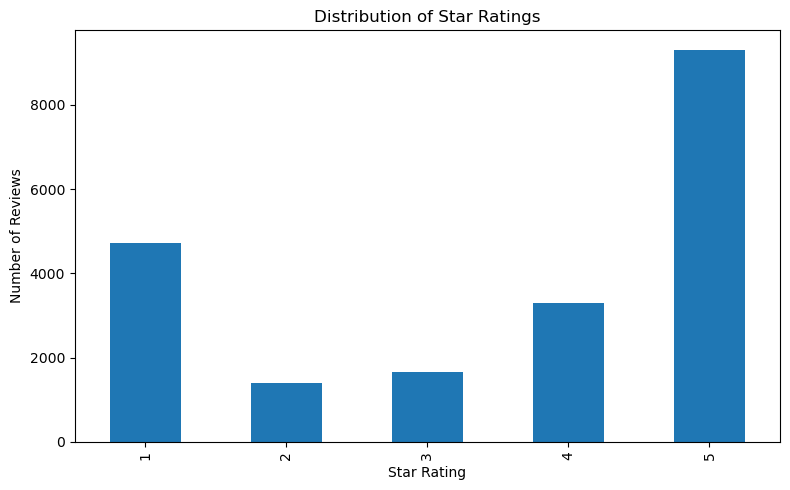

In [40]:
plt.figure(figsize=(8, 5))
df['star_rating'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Star Ratings')
plt.xlabel('Star Rating')
plt.ylabel('Number of Reviews')
plt.tight_layout()
plt.show()

/var/folders/dw/901pycgd1gl3svz7_ypwlb440000gn/T/ipykernel_1823/2322172953.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.set_index('review_date').resample('M').size().plot()


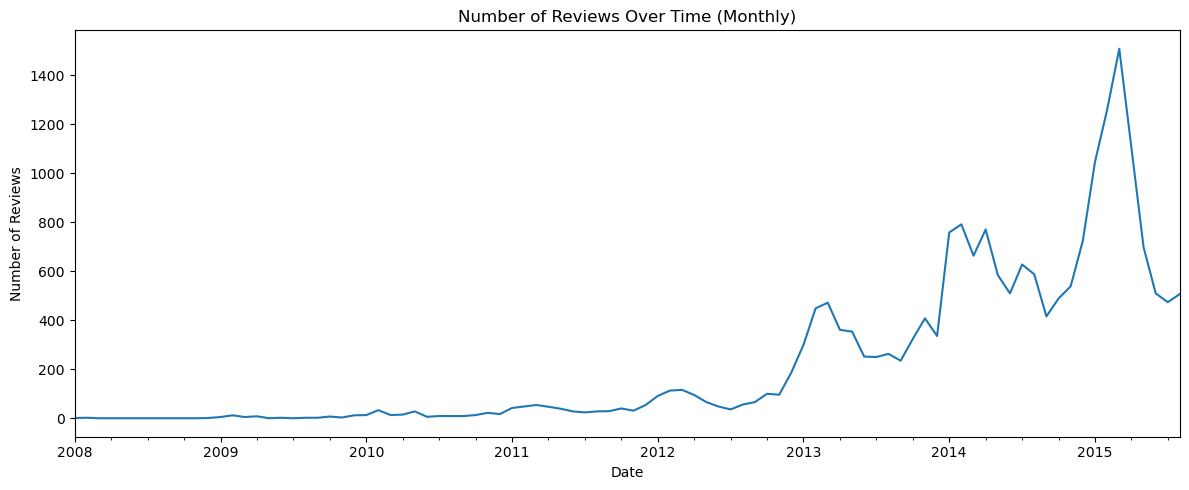

In [41]:
plt.figure(figsize=(12, 5))
df.set_index('review_date').resample('ME').size().plot()
plt.title('Number of Reviews Over Time (Monthly)')
plt.xlabel('Date')
plt.ylabel('Number of Reviews')
plt.tight_layout()
plt.show()

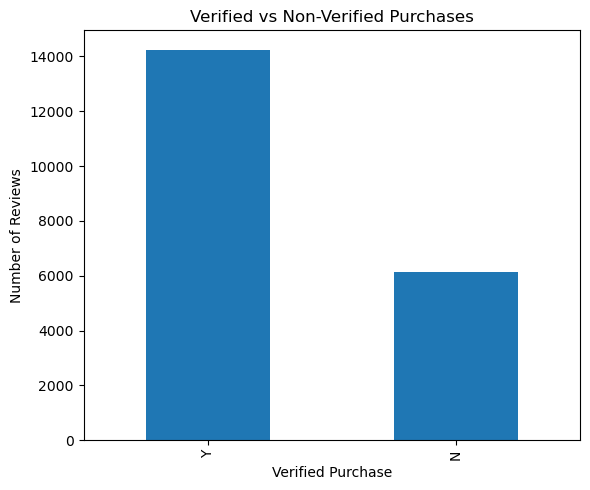

In [42]:
plt.figure(figsize=(6, 5))
df['verified_purchase'].value_counts().plot(kind='bar')
plt.title('Verified vs Non-Verified Purchases')
plt.xlabel('Verified Purchase')
plt.ylabel('Number of Reviews')
plt.tight_layout()
plt.show()

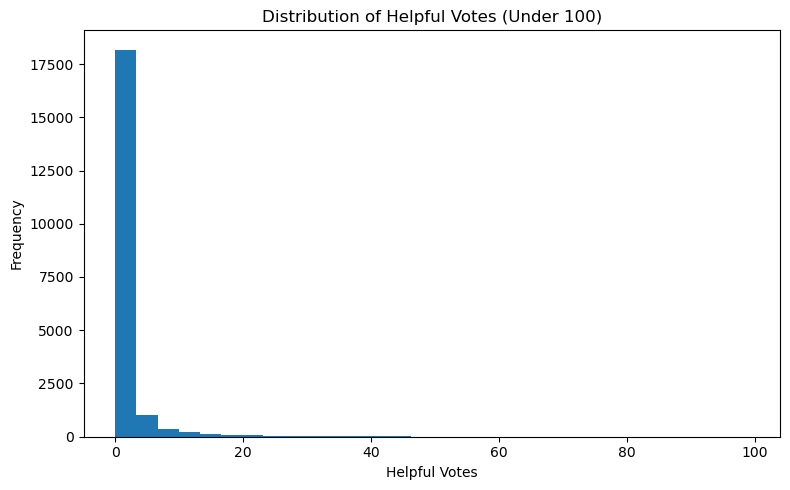

In [43]:
plt.figure(figsize=(8, 5))
df[df['helpful_votes'] < 100]['helpful_votes'].plot(kind='hist', bins=30)
plt.title('Distribution of Helpful Votes (Under 100)')
plt.xlabel('Helpful Votes')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [44]:
reviews_per_customer = df['customer_id'].value_counts().reset_index()
reviews_per_customer.columns = ['customer_id', 'review_count']
reviews_per_customer.head()

,customer_id,review_count
0,17957446,7
1,53055158,5
2,26035883,4
3,51346302,4
4,52318215,4


## Feature Engineering

In [45]:
df['review_length'] = df['review_body'].apply(lambda x: len(str(x).split()))
df['headline_length'] = df['review_headline'].apply(lambda x: len(str(x).split()))
df['helpful_ratio'] = df.apply(lambda row: row['helpful_votes'] / row['total_votes']
                               if row['total_votes'] > 0 else 0, axis=1)

## Sentiment Analysis

In [46]:
sampled_reviews = df[['review_id', 'review_body', 'star_rating', 'helpful_ratio', 'headline_length', 'review_length']].copy()

def analyze_sentiment(text):
    analysis = TextBlob(str(text))
    return analysis.sentiment.polarity

sampled_reviews['sentiment_score'] = sampled_reviews['review_body'].apply(analyze_sentiment)

def label_sentiment(score):
    if score > 0.1:
        return 'Positive'
    elif score < -0.1:
        return 'Negative'
    else:
        return 'Neutral'

sampled_reviews['sentiment_label'] = sampled_reviews['sentiment_score'].apply(label_sentiment)
sampled_reviews['sentiment_label'].value_counts()

sentiment_label
Positive    12531
Neutral      5956
Negative     1878
Name: count, dtype: int64

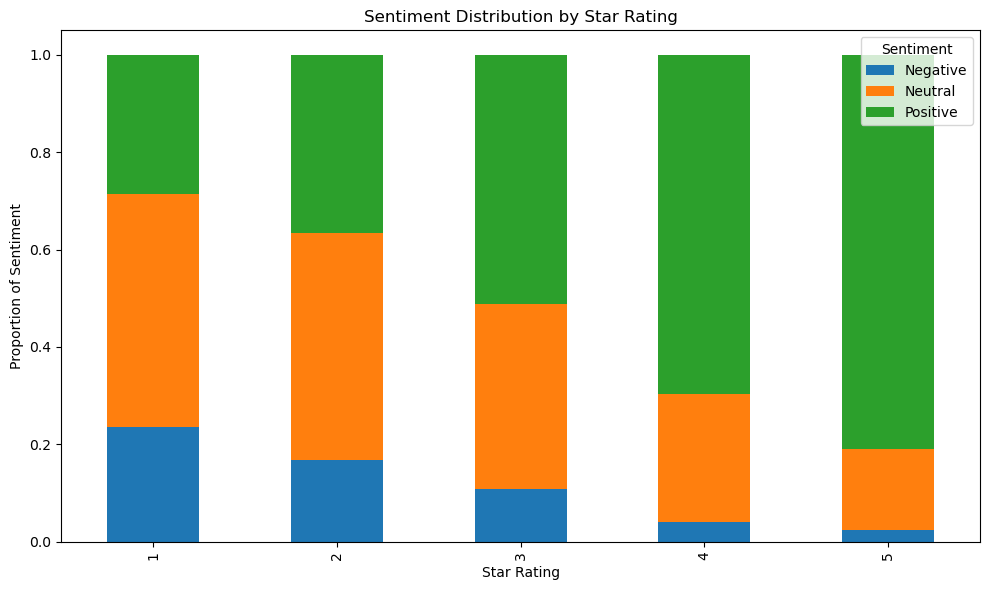

In [47]:
sentiment_vs_rating = sampled_reviews.groupby(['star_rating', 'sentiment_label']).size().unstack().fillna(0)
sentiment_vs_rating_pct = sentiment_vs_rating.div(sentiment_vs_rating.sum(axis=1), axis=0)

sentiment_vs_rating_pct.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Sentiment Distribution by Star Rating')
plt.xlabel('Star Rating')
plt.ylabel('Proportion of Sentiment')
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

## Preliminary Model

In [48]:
sampled_reviews['review_rating'] = sampled_reviews['star_rating'].apply(lambda x: 'Positive' if x > 3 else 'Negative')

# Prepare features
model_data = sampled_reviews[['review_body', 'sentiment_score', 'review_length', 'review_rating','helpful_ratio','headline_length']].dropna()

# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
X_text = tfidf.fit_transform(model_data['review_body'])

# Combine features
X = sp.hstack([X_text, model_data[['sentiment_score', 'review_length']].values])
y = model_data['review_rating']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

# Train model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    Negative       0.83      0.80      0.81      2329
    Positive       0.88      0.90      0.89      3781

    accuracy                           0.86      6110
   macro avg       0.85      0.85      0.85      6110
weighted avg       0.86      0.86      0.86      6110

